# COVID-19 Cases Prediction

基于 [李宏毅 ML 2022 Spring HW1](https://speech.ee.ntu.edu.tw/~hylee/ml/2022-spring.php) 。

## 项目说明

### 目标

进行 regression ，使用过去 4 天的数据预测第 5 天的确诊病例数。

### 数据格式

所有数据在一张二维表中。

行：（training set 不带标签共 2700 行，testing set 共 1078 行）

每行是一次输入的数据。

列标签：（training set 共 118 列，testing set 为 117 列）

- id ，占 1 列。

- 37 个 state ，采用 one-hot 编码表示，占 37 列。

- 以下列标签重复 5 次（天）（共 16 x 5 列）

    - 各项指标（共 15 个）

        - COVID-like illness（4）

        - Behavior Indicators（8）

        - Mental Health Indicators（3）
        
    - Test Positive Cases（1 个）（确诊病例数）
    
        在 testing set 中，第 5 天没有该列。

### 提示

- simple

    Sample code of the course.

- medium

    Feature selection.

- strong

    Different model architectures and optimizers.

- boss

    L2 regularization and try more parameters.

### 实现策略

- 使用 DNN ，输入列，输出预测值。

- loss function 采用 MSE 。

- 使用验证集。

## 导入包

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader

import math   # 本例用到 inf

## 常用函数

In [11]:
def same_seed(seed): 
    torch.backends.cudnn.deterministic = True   # 卷积都使用默认的卷积算法
    torch.backends.cudnn.benchmark = False   # 关闭系统卷积算法选择优化（带随机性）
    np.random.seed(seed)   # 为程序算法设置种子。
    torch.manual_seed(seed)   # 为 CPU 设置种子。
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   # 为所有 GPU 设置种子。

def split_train_valid(data, valid_ratio, seed):
    valid_size = int(len(data) * valid_ratio)
    train_size = len(data) - valid_size
    train_set, valid_set = random_split(data, [train_size, valid_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

## 模型构建

In [12]:
class MyNN(nn.Module):
    def __init__(self, input_dim):
        super(MyNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        t = self.layers(x)
        t = t.squeeze()   # 一次输出一个 batch 的结果:(X, 1)，将其变为一行。
        return t 

## 数据处理

In [13]:
class COVID19Dataset(Dataset):
    def __init__(self, x, y = None):
        self.x = torch.FloatTensor(x)
        if y is None:
            self.y = None
        else:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, idx):
        if self.y == None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]   # 取一行

    def __len__(self):
        return len(self.x)   # x 的长度

def selet_feature(train_data, valid_data, test_data, use_feature = []):   # 选取列
    if use_feature == []:
        feature_idx = list(range(118))
    else:
        feature_idx = [] if -1 not in use_feature else list(range(1, 38))   # id 占一列
        base = 38
        for i in range(5):
            for x in use_feature:
                feature_idx.append(base + x)
            base += 16
    feature_idx_test = feature_idx.copy()   # This is the shallow copt, the deepcopy() is better.
    if 117 not in feature_idx:   # 如果不选 15 ，即计算后的下标 117 列，则在数据分离为 x_train 和 y_train 时，x_train 会被额外去掉一列。
        feature_idx.append(117)   # 至少要将下标 117 列提供给后续的 y_train 。
    else:
        feature_idx_test.remove(117)   # test_data has only 117 columns
    return train_data[:, feature_idx], valid_data[:, feature_idx], test_data[:, feature_idx_test]

## 训练

In [14]:
def train(train_loader, valid_loader, model, config, device):
    criterion = nn.MSELoss(reduction= 'mean')
    optimizer = torch.optim.SGD(model.parameters(), lr= config['learning_rate'], momentum=config['momentum'])
    
    loss_train_per_epoch = []   # the mean loss of every epoch
    loss_valid_per_epoch = []
    n_epoch, best_loss, early_stop_count = config['n_epoch'], math.inf, 0

    for epoch in range(n_epoch):
        model.train()   # 训练
        loss_in_epoch = []
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            predict = model(x)   # forward
            loss = criterion(predict, y)
            loss.backward()
            optimizer.step()
            loss_in_epoch.append(loss.item())

        mean_train_loss = sum(loss_in_epoch) / len(loss_in_epoch)

        model.eval()   # 验证
        loss_in_epoch = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                predict = model(x)
                loss = criterion(predict, y)
            loss_in_epoch.append(loss.item())
        
        mean_valid_loss = sum(loss_in_epoch) / len(loss_in_epoch)

        loss_train_per_epoch.append(mean_train_loss)
        loss_valid_per_epoch.append(mean_valid_loss)

        print(f"##### epoch: {epoch+1} / {n_epoch}")
        print(f"train loss: {mean_train_loss:.4f}")
        print(f"valid loss: {mean_valid_loss:.4f}")

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'])
            print(f"##### save model with valid loss:{best_loss: .4f} #####")
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print("##### early stop ! #####")
            break

    return loss_train_per_epoch, loss_valid_per_epoch, n_epoch, best_loss

## 模型配置

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
config = {
    'seed': 923,
    'use_feature': [15],   # id 列默认不选，state 的 37 列以 -1 表示，列表为空代表全选，列表内数字代表要选择的非 state 的 feature 的编号（从 0 开始）。
    'valid_ratio': 0.2,
    'batch_size': 256,
    'learning_rate': 1e-5,
    'momentum': 0.9,
    'n_epoch': 1000,
    'early_stop': 300,
    'save_path': 'model.ckpt',
    'predict_filename': 'predict.csv'
}

Using cpu device


## main

In [16]:
# def main(config, device) is beter.
same_seed(config['seed'])

# 读取并转化
train_data = pd.read_csv("./data/covid.train.csv").values
test_data = pd.read_csv("./data/covid.test.csv").values

train_data, valid_data = split_train_valid(train_data, 0.2, config['seed'])   # 只打乱行
print(f"train_data size: {train_data.shape}")
print(f"valid_data size: {valid_data.shape}")
print(f"test_data size: {test_data.shape}")

# 特征选取
train_data, valid_data, test_data = selet_feature(train_data, valid_data, test_data, config['use_feature'])   # 选取列
print(f"Total feature number: {test_data.shape[1]}")

# 划分 data 和 label
x_train, y_train = train_data[:, :-1], train_data[:, -1]
x_valid, y_valid = valid_data[:, :-1], valid_data[:, -1]
x_test = test_data
tain_dataset = COVID19Dataset(x_train, y_train)
valid_dataset = COVID19Dataset(x_valid, y_valid)
test_dataset = COVID19Dataset(x_test)

# 划分 batch ，形成 loader
train_loader = DataLoader(tain_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

model = MyNN(input_dim=x_train.shape[1]).to(device)
loss_train_per_epoch, loss_valid_per_epoch, n_epoch, best_loss = train(train_loader, valid_loader, model, config, device)
print(f"best_loss: {best_loss}")

train_data size: (2160, 118)
valid_data size: (539, 118)
test_data size: (1078, 117)
Total feature number: 4
##### epoch: 1 / 10
train loss: 121.8904
valid loss: 106.5623
##### save model with valid loss: 106.5623 #####
##### epoch: 2 / 10
train loss: 107.0936
valid loss: 99.4974
##### save model with valid loss: 99.4974 #####
##### epoch: 3 / 10
train loss: 85.4076
valid loss: 71.4082
##### save model with valid loss: 71.4082 #####
##### epoch: 4 / 10
train loss: 57.4114
valid loss: 43.4525
##### save model with valid loss: 43.4525 #####
##### epoch: 5 / 10
train loss: 26.0176
valid loss: 12.0273
##### save model with valid loss: 12.0273 #####
##### epoch: 6 / 10
train loss: 5.6689
valid loss: 1.7894
##### save model with valid loss: 1.7894 #####
##### epoch: 7 / 10
train loss: 2.3128
valid loss: 3.4628
##### epoch: 8 / 10
train loss: 3.2608
valid loss: 2.5835
##### epoch: 9 / 10
train loss: 2.2547
valid loss: 1.8373
##### epoch: 10 / 10
train loss: 1.9032
valid loss: 1.9545
best_loss

## Loss 图

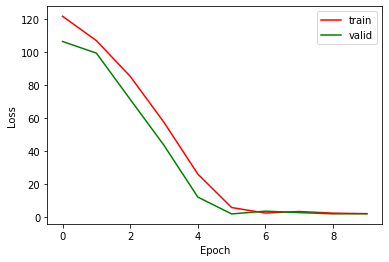

In [17]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
epoch = range(len(loss_train_per_epoch))   # may stop early
plt.plot(epoch, loss_train_per_epoch, "r-", label="train")
plt.plot(epoch, loss_valid_per_epoch, "g-", label="valid")
plt.legend()
plt.show()

## 预测

In [19]:
def predict(model, test_loader, device):
    model.eval()
    predict_record = []
    for x in test_loader:
        x = x.to(device)
        with torch.no_grad():
            t = model(x)
            print(t.device)
            predict_record += t.tolist()
    return predict_record

model = MyNN(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))

result = predict(model, test_loader, device)

# save result
df = pd.DataFrame({'tested_positive': result})
df.to_csv(config['predict_filename'], index_label='id')

cpu
cpu
cpu
cpu
cpu
